## Table system 

#### Install dependencies 
I'll specify in requirement.txt in the future 

In [9]:
!python -m pip install -r requirement.txt


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Download image dataset

In [ ]:

import kaggle 
import os 
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import math

In [3]:

# check whether file is not download yet
if os.path.exists('dataset/Braille') == 0:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('changjianli/braille-dataset-for-scene-text-recognition', path = 'dataset', unzip = True)

### Prepare dataset

Add the image and label to Numpy accordingly

In [4]:
# Function : crop_func, crop image with opencv
def crop_func(event, x, y):
    
    global current_img, crop_img
    
    if event == cv2.EVENT_LBUTTONDOWN:
        x_start, y_start = x,y 
    
    if event == cv2.EVENT_MOUSEMOVE:
        x_end, y_end = x,y
    
    # find x,y min and max 
    x_min = min(x_start, x_end)
    x_max = max(x_start, x_end)
    y_max = max(y_start, y_end)
    y_min = min(y_start, y_end)
    
    # crop image 
    crop_img = current_img[x_min : x_max, y_min : y_max]

In [5]:
# Function : preprocessing, preprocess an image 
def proprocessing(img):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
    # reshape all image to be the same 
    img = cv2.resize(img, (224, 224))
    
    img = cv2.GaussianBlur(img, ksize = (5 ,5), sigmaX= 0)
    
    img = cv2.adaptiveThreshold(img, maxValue = 255, thresholdType=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, adaptiveMethod = cv2.THRESH_BINARY, blockSize=3, C=2)
    
    img = cv2.erode(img, kernel=cv2.getStructuringElement(cv2.MORPH_RECT, (2,2)))
    
    return img
    


In [6]:
# Function : read_images, read and store image value 
def read_images(directory : str):

    images = []
    base_name = []
    
    for img_path in os.listdir(directory):
        
        # Check the format of the file 
        if img_path.endswith(('.jpg', '.png', 'jpeg')):
            # read base_name
            base_name.append(os.path.splitext(img_path)[0])    
            
            # read image 
            img_full_path = os.path.join(directory, img_path)
            img = cv2.imread(img_full_path)
            
            img_pre = proprocessing(img)
            
            images.append(img_pre)
        
    return np.array(images), base_name
    


In [7]:
# Test read file system 
images, base_name = read_images('dataset/Braille/images/train')

(<matplotlib.image.AxesImage at 0x239fde4dd90>, '0000000', (224, 224))

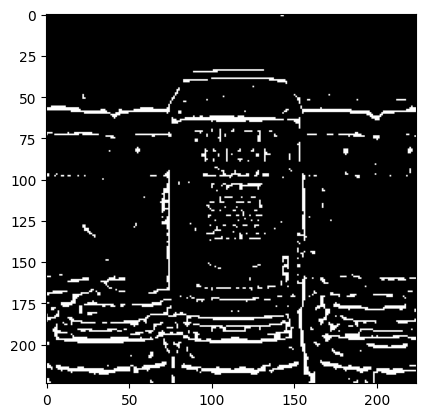

In [8]:
# Compare between before and after resize the image 
plt.imshow(images[1], cmap = 'gray'), base_name[0], images[1].shape

In [9]:
# Function : text_2_num, convert text value to number
def text_2_num(line):
    
    value = []
    for text in line.split(','):
        try: 
            value.append(int(text))
           
        except:
            continue
        
    return value



In [10]:
# Function : read_label, read single file 
def read_label(full_path : str, skip : bool): 
    
    with open(full_path, 'r') as file:
        
        start_line = 1
        location_list = []
    
        if skip:
            next(file) # skip the first line
            start_line = 2
        
        for _ , line in enumerate(file, start_line):
            
            value_list = text_2_num(line)
            location_list.append(value_list)
            
    return np.array(location_list)
                    
                


In [11]:
# Function : read_labels, read label for entire directory
def read_labels(directory : str, base_name : list):
    
    index = 0
    labels_loc = []
    
    for label_path in os.listdir(directory):
        
        # check whether the image name according the label name 
        if os.path.splitext(label_path)[0] == base_name[index]:
            
            full_path = os.path.join(directory, label_path)
            
            labels_loc.append(read_label(full_path, True))   
            
            index = index + 1
            
    return labels_loc

In [12]:
# Test read labels system 
# labels = read_labels(directory='dataset/Braille/labels/train', base_name=base_name)

In [13]:
# labels[0]

### Read Braille index 

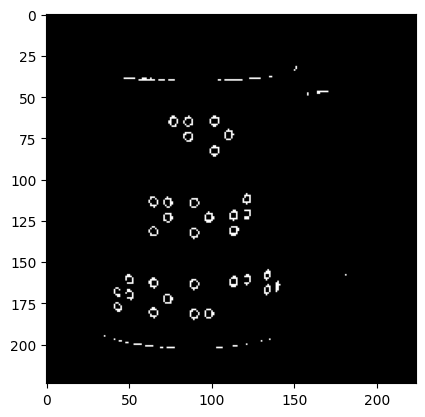

In [14]:
plt.imshow(images[0], cmap="gray")

#### Convert to dot location

In [15]:
# Function : findDot, find dot location
def findDot(img):
    contours, _ = cv2.findContours(img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [16]:
# Function : contour_2_dot, convert contour to dot  
def contour_2_dot(contours, radius : int, threshold : int):
    
    new_contour = []
    
    img = np.zeros((224, 224), dtype=np.uint8)
    for contour in contours:
        
        # Skip the small contour
        if cv2.contourArea(contour) < threshold:
            continue
        
        (x, y), r = cv2.minEnclosingCircle(contour)
        new_contour.append((int(x),int(y)))
        cv2.circle(img, (int(x), int(y)), radius, color=255, thickness=1)
        
    return img, new_contour


In [17]:
# Rotate an image according to the grid 

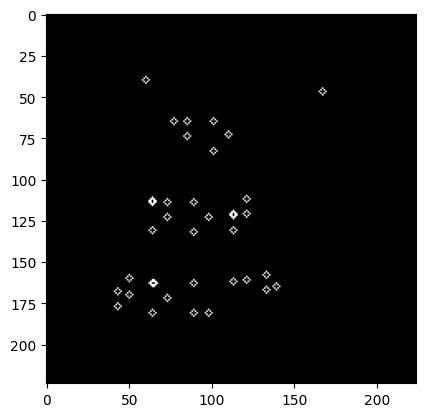

In [18]:
curr_contour = findDot(images[0])
img_draw, newContour = contour_2_dot(curr_contour, 2, 1)
plt.imshow(img_draw, cmap = 'gray')

In [440]:
newContour = np.array(newContour)

In [441]:
# Function : plot_dot, plot location 
def plot_dot(dot : np.ndarray, name : str, x_lim : int = 224, y_lim : int = 224):

    plt.xlim(0 , x_lim)
    plt.ylim(0 , y_lim)
    
    plt.gca().invert_yaxis()
    plt.axis('equal')
    
    plt.scatter(dot[:,0], dot[:,1])
    plt.title(name)
    
    plt.grid(True, linestyle = ':')
    plt.show()

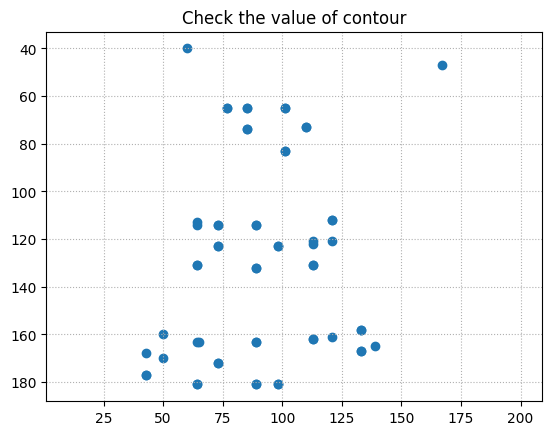

In [442]:
plot_dot(newContour, "Check the value of contour")

#### Preprocess Braille dot

In [443]:
# Function : filter_contour, remove the dot that has min length less and greater than range
def filter_contour(contours : np.ndarray) -> np.ndarray:

    """
    This function to approximate contours value of y axis to be more discrete and ly on the grid
    
    Parameter : contour to filter 
    Return : contour after filtering, Average distance 
    
    DISCLAMER : This function may have a problem with character A 
    """
    
    # delete duplicate value 
    contours = np.unique(contours, axis = 0)
    
    dist = pdist(contours, metric = "euclidean")
    
    dist_square_form = squareform(dist) 
    sorted_id = [np.argpartition(dist_square_form[i], 5) for i in range(contours.shape[0])]
    
    min_id = []
    
    for i in range(contours.shape[0]):
        for j in range(5):

            temp = dist_square_form[i][sorted_id[i][j]]
            
            if temp != 0:
                 
                min_id.append([i, sorted_id[i][j]])
                break
                
    row_id = np.array(min_id)[:,0]
    col_id = np.array(min_id)[:,1]
    
    non_zero_min_dist = dist_square_form[row_id,col_id]
    avg_dist = np.mean(non_zero_min_dist)
    
    
    # check contour again and delete the one which is below or out threshold
    mask = (non_zero_min_dist < avg_dist - (avg_dist / 2)) | (non_zero_min_dist > math.sqrt(5) * avg_dist)
    contours = np.delete(contours, mask, axis = 0)
    
    return contours, avg_dist
    

In [444]:
new_contour_fil, avg_dist = filter_contour(newContour)
new_contour_fil.shape

(29, 2)

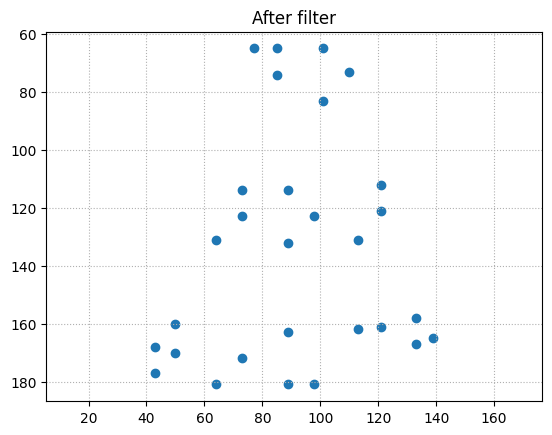

In [445]:
plot_dot(new_contour_fil, "After filter")

#### Group and find Braille index

In [446]:
threshold = int(avg_dist / 4)
new_table = np.zeros((5,3))
curr_contour = new_contour_fil

In [447]:
# Function : check_dot_threshold, find whether location is near the dot contour
def check_dot_threshold(contour : np.ndarray, location : list) -> int:

    """ Check whether the contours is in cover area of threshold or not 

        Parameter : location to check
        Return index of that contours
            case : If have contour -> contour position 
            else : -1
    
    """
    # find the index of center in the contour 
    index_found = np.where((location[1] <= contour[:,1] + threshold) & (location[1] >= contour[:,1] - threshold) & (location[0] >= contour[:,0] - threshold) & (location[0] <= contour[:,0] + threshold))
    if len(index_found[0]) != 0:
        return index_found[0][0]
    return -1    

Check function : check_dot_threshold

In [448]:
help(check_dot_threshold)

Help on function check_dot_threshold in module __main__:

check_dot_threshold(contour: numpy.ndarray, location: list) -> int
    Check whether the contours is in cover area of threshold or not

    Parameter : location to check
    Return index of that contours
        case : If have contour -> contour position
        else : -1



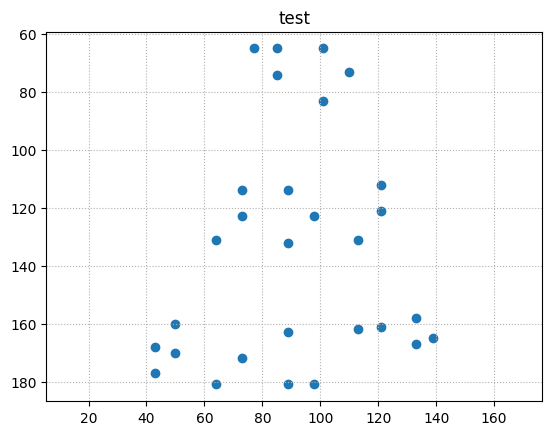

In [449]:
# plot image with dot 
plot_dot(new_contour_fil, name = 'test')

In [450]:
index = check_dot_threshold(curr_contour, curr_contour[0] + [-2, 2])
index

np.int64(0)

In [451]:
table = np.zeros((5,3))

In [452]:
# Function : traversion_check , recursive check neighbor
def traversion_check(contour : np.ndarray, current_pos : np.ndarray, curr_row : int, curr_col : int): 
    
    global table
    global chk_ind
    
    # set value of table 
    table[curr_row][curr_col] = 1
    
    # check on its neighbor left down, right down, left, right, down
    # format x,y
    step_check = [[-1, 1], [1, 1], [-1, 0], [1, 0], [0, 1]]
    array_step = np.array(step_check) * avg_dist
    array_step = array_step.astype(int)
    
    index = check_dot_threshold(contour, current_pos)
    if index != -1:
        chk_ind.append(index)
    for i in range(len(step_check)):
        
        location_2_check = current_pos + array_step[i]
        
        index = check_dot_threshold(contour, location_2_check.tolist()) 
        # print(index)
        new_row = curr_row + step_check[i][1]
        new_col = curr_col + step_check[i][0]
        if (index != -1):
            chk_ind.append(index)   
                    
            if table[new_row, new_col] != 1 and ((new_row < table.shape[0] and new_row >= 0) or (new_col < table.shape[1] and new_col >= 0)):
                traversion_check(contour, location_2_check, new_row , new_col)

    chk_ind = np.array(chk_ind)
    chk_ind = np.unique(chk_ind).tolist()

Check function : traversion_check 

In [453]:
chk_ind = []
table = np.zeros((5,3))

In [454]:
index = 4
traversion_check(new_contour_fil, new_contour_fil[index], 2, 1)
new_contour_fil[index], table, chk_ind 

(array([ 64, 131]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 [4])

In [455]:
# Select a row to assume position of row 

num_contours = 3
min_y = np.min(curr_contour[:,1], axis = 0)
row_tst_list = []

for i in range(num_contours):
    rand_table = np.random.randint(0,2, (5,3))
    loc_1 = np.where(rand_table == 1)
    fir_row_one = np.min(loc_1[0])
    min_location = [3,min_y + avg_dist * fir_row_one]
    row_tst_list.append([min_location, rand_table])

print([loc[1] for loc, _ in row_tst_list])



[np.float64(65.0), np.float64(65.0), np.float64(65.0)]


In [456]:
# Function : braille_index_row, find index of Braille on each row
def braille_index_row(group_char_list : list) -> list:
    
    length = len(group_char_list)
    
    # all table 
    table_list = []
    
    
    # find min y for this group 
    min_braille = 6
    begin_location_y = [group_char_list[i][0][1] for i in range(len(group_char_list))]
    max_location_y = max(begin_location_y)
    list_all_braille = []
    
    for i in range(length):
        
        index = 0
        for j in range(2):
            check_value = max_location_y - j * avg_dist
            bound_check = j * avg_dist
            if begin_location_y[i] > check_value - threshold and begin_location_y[i] < check_value + threshold: 
                break 
            index = index + 1
        
        # delete the first 2 - j row 
        new_table = np.delete(group_char_list[i][1], [x for x in range(index)], axis = 0)
        
        # cut where row is all 0
        table_list.append(new_table)
    
        # calculate the table value to index format 
        # finding where value is 1 
        index_1 = np.where(table_list[i] == 1)
        
        list_braille_index = []
        
        for i in range(len(index_1[0])):
            list_braille_index.append(index_1[0][i] * 2 + index_1[1][i] + 1)
        
        if min_braille > min(list_braille_index):
            min_braille = min(list_braille_index)    

        list_all_braille.append(list_braille_index)
    
    # print(min_braille)
    list_all_braille = [[item - 2 * ((min_braille - 1) // 2) for item in sublist] for sublist in list_all_braille]
    return list_all_braille        


Check function : braille_index_row

In [457]:
used_contour = new_contour_fil

In [458]:
braille_index_row(row_tst_list)


[[np.int64(2), np.int64(7), np.int64(9), np.int64(9)],
 [np.int64(1),
  np.int64(3),
  np.int64(5),
  np.int64(6),
  np.int64(7),
  np.int64(9)],
 [np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(6),
  np.int64(7),
  np.int64(8),
  np.int64(9),
  np.int64(9),
  np.int64(10),
  np.int64(11)]]

In [459]:
def delete_zero_col(table : np.ndarray) -> np.ndarray:
    
    # check if there no value of one in which col -> delete that col 
    one_col = np.where(table == 1)[1]
    one_col = np.unique(one_col)
    
    zero_col = [i for i in range(table.shape[1]) if i not in one_col]
    new_table = np.delete(table, zero_col, axis = 1)
    
    return new_table

In [468]:
used_contour = new_contour_fil

In [469]:
# Function read_braille : loop read the value of braillle for all group
def read_braille():
    
    global used_contour
    global chk_ind
    """ Using threshold value to predict the Braille index 
    Step #1 : Start with the minimum coordinate row before col 
    Step #2 : Loop Row : check the value of the same row first by using threshold value
        Step #2.1 : Loop for each column : check the value of the same col and group 2 col 
            Step #2.1.1 : Loop for row in each col group 3 -> write the index of that Braille -> Delete the contour 
    Step #3 : Go back to Step #1 untill there's no contour to check 
    """
    
    # sort with y value 
    sorted_id = np.argsort(np.array(used_contour[:,1]))
    # sort used_contour
    used_contour = used_contour[sorted_id]
    # set min value 
    min_dot_location = used_contour[0]
    
    # list to store data
    Braille_index_list = [] # collect value of all row 
    list_table_row = [] # collect postion and table of row value 
    chk_ind = [] # return value from traversion whether position is checked
    Braille_index_output = None
    
    while used_contour.size != 0:
        # edit the value table 
        global table 
        table = np.zeros((5,3))
        traversion_check(used_contour, used_contour[0], 2, 1)
        
        # print(chk_ind)
        # print(used_contour)
        used_contour = np.delete(used_contour, chk_ind, axis = 0)
        chk_ind = []
        
        table = delete_zero_col(table)
        # print(table)
        list_table_row.append([min_dot_location, table])

        if used_contour.size == 0:
            break
        
        # if skip to the next line
        if used_contour[0,1] > min_dot_location[1] + 3 * avg_dist:
            # read the value for previous row
            Braille_index_output = braille_index_row(sorted(list_table_row, key=lambda x: x[0][0]))
            # print(Braille_index_output)
            Braille_index_list.append(Braille_index_output)
            
            list_table_row = []
            min_dot_location = used_contour[0]

    # For the last line
    Braille_index_list.append(Braille_index_output)
    
    return Braille_index_list    
    

Check function : read_braille

In [470]:
read_braille()

[[[np.int64(1), np.int64(2), np.int64(4)],
  [np.int64(1), np.int64(4), np.int64(5)]],
 [[np.int64(2), np.int64(4), np.int64(5)],
  [np.int64(1), np.int64(3)],
  [np.int64(1), np.int64(4), np.int64(5)],
  [np.int64(1)]],
 [[np.int64(2), np.int64(4), np.int64(5)],
  [np.int64(1), np.int64(3)],
  [np.int64(1), np.int64(4), np.int64(5)],
  [np.int64(1)]]]